# Reconstruction of vertical EDJ structure from hydrographic Argo data, vertical wavelength estimation

In [ ]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import matplotlib.gridspec as gs
import h5py
import cftime
import matplotlib.dates as mdates
from astropy import timeseries
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from warnings import filterwarnings
from scipy.optimize import lsq_linear
import dask.config as dc
from dask_jobqueue import SLURMCluster
from dask.distributed import Client
from scipy.io import savemat
from scipy.io import loadmat
import gsw
from scipy import signal

import sys
sys.path.append("modules/")
import density_binning
import geostrophy
import lombscargle

In [ ]:
# set up batchjob
cluster = SLURMCluster(
    partition="cluster",
    walltime="08:00:00",
    cores=16,
    processes=4,
    memory="60 GB",
    env_extra=[
        "export LC_ALL=en_US.UTF-8",
        "export LANG=en_US.UTF-8"],
    interface="ib0")

In [ ]:
client = Client(cluster)
# add nodes
cluster.scale(64)


---------------
# Calculate in-situ density and squared buoyancy frequency from hydrographic Argo data

In [ ]:
datapath = "data/ftp.ifremer.fr/ifremer/argo/geo/atlantic_ocean/"

years = np.arange(2001,2020,1)
months = np.arange(1,13,1)

filterwarnings("ignore")
dataset_list = []

for year in years:
    for month in months:
        monthdir = f"{year:.0f}/{month:02d}/"
        dataset = density_binning.calc_bin_density(datapath+monthdir, 5, 1, 10)
        dataset_list.append(dataset)
    
# missing months in 2020 (only 1 to 6)
years = np.arange(2020,2021,1)
months = np.arange(1,7,1)

filterwarnings("ignore")
for year in years:
    for month in months:
        monthdir = f"{year:.0f}/{month:02d}/"
        dataset = density_binning.calc_bin_density(datapath+monthdir, 5, 1, 10)
        dataset_list.append(dataset)
        
binned_rho_SA_CT_Nsq = xr.concat(dataset_list, "time")

# save as netcdf
binned_rho_SA_CT_Nsq.to_netcdf("derived_data/binned_rho_SA_CT_Nsq.nc", mode="w")

--------------------
# Calculate \<N\> and N_0 as in Youngs and Johnson (2015), for scaling and stretching (needed for calculation of vertical wavenumber, see below)

In [ ]:
N_mean = np.sqrt(binned_rho_SA_CT_Nsq.Nsquared.sel(lat=slice(-1,1))).mean(dim="time").mean(dim="lon").mean(dim="lat")

# smoothing with 200dbar half-width Hanning window (like in Youngs and Johnson, 2015)
N_win = 200 // 10 + 1    # (200dbar // length of the sample interval)
win = signal.windows.hann(N_win)    # Hann window
win /= win.sum()        # win = win / win.sum()   Normalisation
win = xr.DataArray(win, dims=['window'])

N_mean_filt = N_mean.rolling(midpressure=N_win, center=True).construct('window').dot(win, dims=['window'])

# prepare N_mean_filt (extend missing values due to filtering at top and bottom)
N_mean_filt_2 = N_mean_filt.values
N_mean_filt_2[0:10] = N_mean_filt_2[10]
N_mean_filt_2[-10:] = N_mean_filt_2[-11]

N_m_mid = xr.Dataset({"N_m_mid": (["pressure"], N_mean_filt_2)},
                    coords={"pressure": (["pressure"], N_mean_filt.midpressure)})
# put this on the right pressure levels for further analysis
N_m = xr.Dataset({"N_m": (["pressure"], N_m_mid.N_m_mid.interp(coords={"pressure": np.arange(405, 2005, 10)}))},
                coords={"pressure": (["pressure"], np.arange(405, 2005, 10))})  

## Figure 4

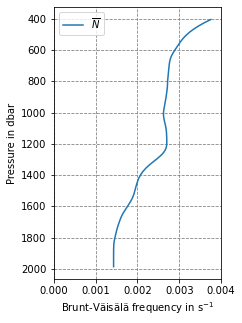

In [23]:
plt.figure(figsize=(3,5))

ax = plt.subplot(111)
N_m.N_m.sel(pressure=slice(400,2000)).plot(y="pressure", yincrease=False)
plt.grid(color="grey", linestyle="dashed")
ax.set_xlim([0, 0.004])
plt.ylabel("Pressure in dbar")
plt.xlabel(r"Brunt-Väisälä frequency in s$^{-1}$")
plt.legend((r"$\overline{N}$",))

plt.savefig("Figures/Figure4_N_profile.pdf", bbox_inches="tight")

In [ ]:
# calculate N_0, save N profile as dataset for reproducibility of scaling and stretching
N_zero = N_m.mean(dim="pressure")
N_m.to_netcdf("derived_data/Nsq_profile.nc", mode="w")

----------------------------------------
# Calculate second meridional derivative of density

In [ ]:
density_dy2 = geostrophy.density_dy2(binned_rho_SA_CT_Nsq, 1, take_further_values=True)

## Supporting Figure (overview plot second meridional derivative of density from hydrographic Argo data)

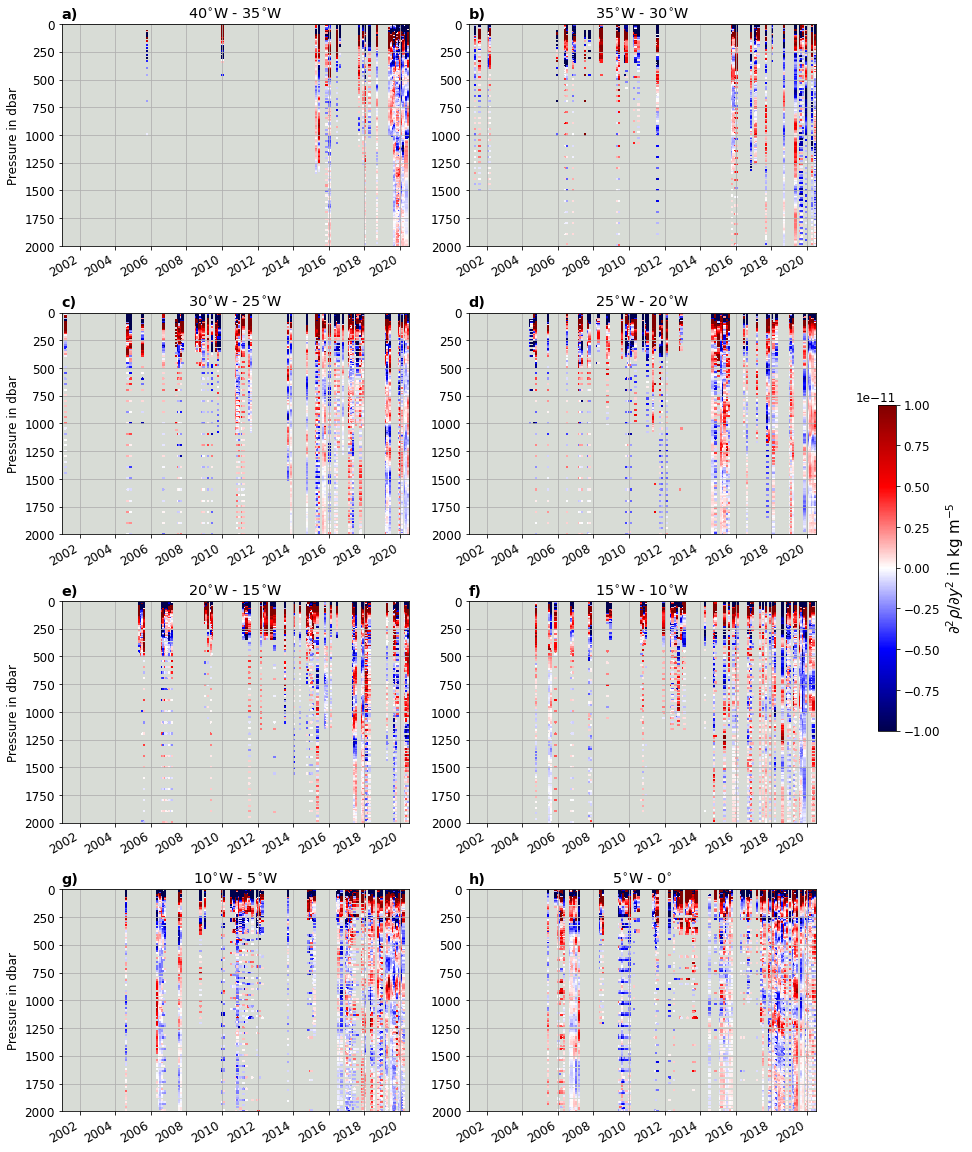

In [10]:
matplotlib.rcParams["font.size"]=12

plt.figure(figsize=(15,20))

gr = gs.GridSpec(4, 3, hspace=0.30, wspace=0.25, width_ratios=[15,15,1])

ax1 = plt.subplot(gr[0,0])
dat1 = density_dy2.density_dy2[:,:,0,2].transpose().plot(cmap="seismic",vmin=-0.1e-10, vmax=0.1e-10, yincrease=False, add_colorbar=False, rasterized=True)
ax1.set_facecolor("xkcd:light grey")
plt.xlabel("")
plt.ylabel("Pressure in dbar")
ax1.set_xticks([str(i) + "-01-02" for i in np.arange(2002, 2022, 2)]) 
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.title(f"{-(density_dy2.lon[2].values-2.5):.0f}" + r"$^{\circ}$W - " + f"{-(density_dy2.lon[2].values+2.5):.0f}" + r"$^{\circ}$W")
plt.title("a)", loc="left", fontweight="bold")
plt.grid()

ax2 = plt.subplot(gr[0,1])
density_dy2.density_dy2[:,:,0,3].transpose().plot(cmap="seismic",vmin=-0.1e-10, vmax=0.1e-10, yincrease=False, add_colorbar=False, rasterized=True)
ax2.set_facecolor("xkcd:light grey")
plt.xlabel("")
plt.ylabel("")
plt.title(f"{-(density_dy2.lon[3].values-2.5):.0f}" + r"$^{\circ}$W - " + f"{-(density_dy2.lon[3].values+2.5):.0f}" + r"$^{\circ}$W")
plt.title("b)", loc="left", fontweight="bold")
ax2.set_xticks([str(i) + "-01-02" for i in np.arange(2002, 2022, 2)]) 
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.grid()

ax3 = plt.subplot(gr[1,0])
density_dy2.density_dy2[:,:,0,4].transpose().plot(cmap="seismic",vmin=-0.1e-10, vmax=0.1e-10, yincrease=False, add_colorbar=False, rasterized=True)
ax3.set_facecolor("xkcd:light grey")
plt.xlabel("")
plt.ylabel("Pressure in dbar")
plt.title(f"{-(density_dy2.lon[4].values-2.5):.0f}" + r"$^{\circ}$W - " + f"{-(density_dy2.lon[4].values+2.5):.0f}" + r"$^{\circ}$W")
plt.title("c)", loc="left", fontweight="bold")
ax3.set_xticks([str(i) + "-01-02" for i in np.arange(2002, 2022, 2)]) 
ax3.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.grid()

ax4 = plt.subplot(gr[1,1])
density_dy2.density_dy2[:,:,0,5].transpose().plot(cmap="seismic",vmin=-0.1e-10, vmax=0.1e-10, yincrease=False, add_colorbar=False, rasterized=True)
ax4.set_facecolor("xkcd:light grey")
plt.xlabel("")
plt.ylabel("")
plt.title(f"{-(density_dy2.lon[5].values-2.5):.0f}" + r"$^{\circ}$W - " + f"{-(density_dy2.lon[5].values+2.5):.0f}" + r"$^{\circ}$W")
plt.title("d)", loc="left", fontweight="bold")
ax4.set_xticks([str(i) + "-01-02" for i in np.arange(2002, 2022, 2)]) 
ax4.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.grid()

ax5 = plt.subplot(gr[2,0])
density_dy2.density_dy2[:,:,0,6].transpose().plot(cmap="seismic",vmin=-0.1e-10, vmax=0.1e-10, yincrease=False, add_colorbar=False, rasterized=True)
ax5.set_facecolor("xkcd:light grey")
plt.xlabel("")
plt.ylabel("Pressure in dbar")
plt.title(f"{-(density_dy2.lon[6].values-2.5):.0f}" + r"$^{\circ}$W - " + f"{-(density_dy2.lon[6].values+2.5):.0f}" + r"$^{\circ}$W")
plt.title("e)", loc="left", fontweight="bold")
ax5.set_xticks([str(i) + "-01-02" for i in np.arange(2002, 2022, 2)]) 
ax5.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.grid()

ax6 = plt.subplot(gr[2,1])
density_dy2.density_dy2[:,:,0,7].transpose().plot(cmap="seismic",vmin=-0.1e-10, vmax=0.1e-10, yincrease=False, add_colorbar=False, rasterized=True)
ax6.set_facecolor("xkcd:light grey")
plt.xlabel("")
plt.ylabel("")
plt.title(f"{-(density_dy2.lon[7].values-2.5):.0f}" + r"$^{\circ}$W - " + f"{-(density_dy2.lon[7].values+2.5):.0f}" + r"$^{\circ}$W")
plt.title("f)", loc="left", fontweight="bold")
ax6.set_xticks([str(i) + "-01-02" for i in np.arange(2002, 2022, 2)]) 
ax6.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.grid()

ax7 = plt.subplot(gr[3,0])
density_dy2.density_dy2[:,:,0,8].transpose().plot(cmap="seismic",vmin=-0.1e-10, vmax=0.1e-10, yincrease=False, add_colorbar=False, rasterized=True)
ax7.set_facecolor("xkcd:light grey")
plt.xlabel("")
plt.ylabel("Pressure in dbar");
plt.title(f"{-(density_dy2.lon[8].values-2.5):.0f}" + r"$^{\circ}$W - " + f"{-(density_dy2.lon[8].values+2.5):.0f}" + r"$^{\circ}$W")
plt.title("g)", loc="left", fontweight="bold")
ax7.set_xticks([str(i) + "-01-02" for i in np.arange(2002, 2022, 2)]) 
ax7.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.grid()

ax8 = plt.subplot(gr[3,1])
density_dy2.density_dy2[:,:,0,9].transpose().plot(cmap="seismic",vmin=-0.1e-10, vmax=0.1e-10, yincrease=False, add_colorbar=False, rasterized=True)
ax8.set_facecolor("xkcd:light grey")
plt.xlabel("")
plt.ylabel("");
plt.title(f"{-(density_dy2.lon[9].values-2.5):.0f}" + r"$^{\circ}$W - " + f"{(density_dy2.lon[9].values+2.5):.0f}" + r"$^{\circ}$")
plt.title("h)", loc="left", fontweight="bold")
ax8.set_xticks([str(i) + "-01-02" for i in np.arange(2002, 2022, 2)]) 
ax8.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.grid()

ax9 = plt.subplot(gr[:,2])
ax9.set_visible(False)
cbax = inset_axes(ax9, width="80%", height="30%", loc="center")
cb = plt.colorbar(dat1, cax=cbax, orientation="vertical")
cb.set_label(r"$\partial^2 \rho / \partial y^2$ in kg m$^{-5}$", fontsize=15)

plt.savefig("Figures/Supporting_Figure_hydrographic_data_density_dy2.pdf", bbox_inches="tight", dpi=300)

# Define function for temporal harmonic filtering at EDJ frequency

In [ ]:
# harmonic fit

def xr_lsq(t, pyy, omega, dim, **kwargs):
    """Lsq harmonic fit."""
    
    def _lsq_ufunc(pyy, t, omega):
        valid = ~np.isnan(pyy)
        if ~np.any(valid):
            return np.array([np.nan, np.nan])
        A = np.vstack((np.cos(omega * t[valid]), np.sin(omega * t[valid]))).T
        result = lsq_linear(A, pyy[valid])
        return result.x

    def _lsq_along_axis(pyy, t, omega):
        return np.apply_along_axis(_lsq_ufunc, -1, pyy, t, omega)

    params = xr.apply_ufunc(
        _lsq_along_axis, pyy, t, omega, input_core_dims=[[dim], [dim], []],
        output_core_dims=[('coeff',)]
    )
    return params


def fit_edj_harmonic(dataarray, tdays=False):
    
    if isinstance(tdays, bool):
        tdays = dataarray.tdays
    
    edj_freq = 0.2174 / 365.25   # in 1/days
    omega =  2 * np.pi * edj_freq

    coeff = xr_lsq(tdays, dataarray, omega, 'time')
    a, b = coeff.isel(coeff=0), coeff.isel(coeff=1)
    amp_fit = np.sqrt(a ** 2 + b ** 2)
    phase_fit = np.arctan2(-b, a)

    temporalharmonic = amp_fit * np.cos(omega * tdays + phase_fit)
    return temporalharmonic

# Define function for geostrophic velocity reconstruction

In [ ]:
def zonal_velocity_reconstruction(data, rho, ref_u, dp, p_ref_u=1000):
    """reconstruct equatorial zonal velocity from d2rho/dy2
    
    Input:
    data (xarray DataArray): d2rho/dy2
    rho (xarray DataArray): in-situ density profile
    ref_u (xarray DataArray): reference velocity
    dp (xarray DataArray): pressure grid spacing (in Pascal)
    p_ref_u=1000 (scalar): pressure in dbar at which reference velocity is located
    
    Returns:
    velocity (xarray Dataset)
    """
    
    # define constants
#     g = 9.78    # gravity acceleration in m/s^2 (at equator)
    rho_zero = 1027   # mean ocean density in kg/m^3   (should maybe be more specific, maybe mean of the region?)
    beta = 2.3e-11   # in 1/(m*s), from Gill, p. 434
    
    C = -1 / (rho_zero * beta)
    
    data2 = data / rho
    
    # reconstruct zonal velocity field
    # above 1000 m:
    zonal_velocity_data_above = (C * (data2.interpolate_na(dim="pressure", method="linear", limit=5
                                     ).sel(pressure=slice(0, p_ref_u)
                                     ).sortby("pressure", ascending=False) * -dp
                                     ).cumsum(dim="pressure", skipna=False)
                            + ref_u)
    
    # below 1000 m:
    zonal_velocity_data_below = (C * (data2.interpolate_na(dim="pressure", method="linear", limit=5
                                     ).sel(pressure=slice(p_ref_u, 2000)
                                     ).sortby("pressure", ascending=True) * dp
                                     ).cumsum(dim="pressure", skipna=False)
                            + ref_u)
    
    # combine dataset again
    zonal_velocity_dataset_fitted = xr.concat([zonal_velocity_data_above.sortby("pressure", ascending=True), zonal_velocity_data_below], "pressure")
    
    # detrend (scipy detrend cannot work with NaNs)
    zonal_velocity = np.zeros((len(zonal_velocity_dataset_fitted.time), 159, 12)) + np.nan
    for l in range(0, 12):
        for i in range(0, len(zonal_velocity_dataset_fitted.time)):
            if np.sum(np.isfinite(zonal_velocity_dataset_fitted[i,:,l])) > 20:
                m, b = np.polyfit(zonal_velocity_dataset_fitted.pressure[np.isfinite(zonal_velocity_dataset_fitted[i,:,l])], 
                                  zonal_velocity_dataset_fitted[i,np.isfinite(zonal_velocity_dataset_fitted[i,:,l]),l], 1)
                zonal_velocity[i,:,l] = zonal_velocity_dataset_fitted[i,:,l].values - (m*zonal_velocity_dataset_fitted.pressure + b)
        
    # make dataset with detrended zonal velocity
    zonal_velocity_detrended = xr.Dataset({"detrended_u": (["time", "pressure", "lon"], zonal_velocity)},
                                      coords={"pressure": (["pressure"], zonal_velocity_dataset_fitted.pressure.values),
                                              "lon": (["lon"], zonal_velocity_dataset_fitted.lon.values),
                                              "time": (["time"], zonal_velocity_dataset_fitted.time.values)})
    
    return zonal_velocity_dataset_fitted, zonal_velocity_detrended

# Figure 10, Geostrophic velocity reconstruction

In [ ]:
# density profile needed for thermal wind equation
rho_profile = binned_rho_SA_CT_Nsq.sel(lat=0, lon=slice(-40,0)).binned_density.mean(dim="time").mean(dim="lon")

# reference velocity at 1000m depth, from YoMaHa'07 dataset
ref_u_orig = xr.open_dataset("derived_data/reference_u_1000m_depth.nc")

# make new time coordinate (time in days), for temporal harmonic fit
density_dy2["tdays"] = xr.DataArray(mdates.date2num(density_dy2.time), dims=["time"])
ref_u_orig["tdays"] = xr.DataArray(mdates.date2num(ref_u_orig.time), dims=["time"])

# velocity reconstruction from original d2rho/dy2 dataset
velocity, velocity_detrended = zonal_velocity_reconstruction(density_dy2.density_dy2.sel(pressure=slice(410,2000)).squeeze(), rho_profile.sel(pressure=slice(410,2000)), 
                                                             ref_u_orig.reference_u_1000m, 1e5, p_ref_u=1000)

# velocity reconstruction from temporally filtered d2rho/dy2 dataset
density_dy2_filtered = fit_edj_harmonic(density_dy2.density_dy2.squeeze(), tdays=density_dy2.tdays)
ref_u_filtered = fit_edj_harmonic(ref_u_orig.reference_u_1000m, tdays=ref_u_orig.tdays)

velocity_temporalharmonic, velocity_temporalharmonic_detrended = zonal_velocity_reconstruction(
    density_dy2_filtered.transpose("time", "pressure", "lon").sel(pressure=slice(410,2000)), rho_profile, ref_u_filtered, 1e5, p_ref_u=1000)

In [ ]:
# temporally filtered mooring data for comparison

with h5py.File("data/Mooring_data/velocities_23W_2001_2019_interp.mat", "r") as file:
    U = np.array(file['U'])
    V = np.array(file['V'])
    P = np.array(file['P'])
    time = np.array(file['TIME'])
    
vel_23W_obs = xr.Dataset({'u':(['pressure', 'time'], U.transpose()),
                         'v':(['pressure', 'time'], V.transpose())},
                        coords={'pressure': P[:,0],
                               'time': cftime.num2date(time[0,:]-365, 'days since 0001-01-01')}
                        )
vel_23W_obs = vel_23W_obs.chunk({'pressure':20,'time':100})

# binning of mooring data into monthly, 10dbar bins
mooring_monthly = vel_23W_obs.u.resample(time="1MS").mean(dim="time")
depth = np.arange(5, 4505, 10)
mooring = mooring_monthly.interp(coords={"pressure": depth})

# temporal harmonic filter
mooring["tdays"] = xr.DataArray(mdates.date2num(mooring.time), dims=["time"])
mooring_filtered = fit_edj_harmonic(mooring.u, tdays=mooring.tdays)

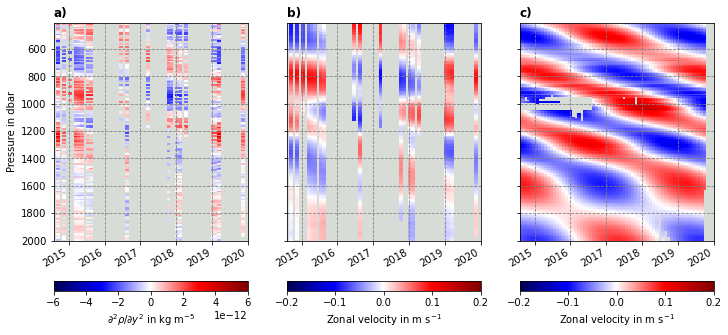

In [23]:
# comparison mooring/reconstructed velocity

plt.figure(figsize=(16, 5))

gr = gs.GridSpec(2, 4, height_ratios=[5,1])

########################################################################

ax1 = plt.subplot(gr[0:2,0])
density_dy2_filtered.transpose().where((np.isfinite(density_dy2.density_dy2))
                                                    ).sel(lon=-22.5, time=slice("2013", "2021"), pressure=slice(410,2000)).transpose().plot(yincrease=False,
                                                    cbar_kwargs={"label": r"$\partial^2 \rho / \partial y^2$ in kg m$^{-5}$", "fraction": 0.05,
                                                                 "orientation": "horizontal"},
                                                    vmin=-6e-12, vmax=6e-12,
                                                    cmap="seismic", rasterized=True)
ax1.set_xlim("2014-08-01", "2020-01-01")
ax1.set_xticks(("2015-01-02", "2016-01-02", "2017-01-02", "2018-01-02", "2019-01-02", "2020-01-02"))
plt.ylabel("Pressure in dbar")
plt.xlabel("")
plt.title("")
plt.title("a)", loc="left", fontweight="bold")
ax1.set_facecolor("xkcd:light grey")
plt.grid(color="grey", linestyle="dashed")
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

###############################################################

ax2 = plt.subplot(gr[0:2, 1])
velocity_temporalharmonic_detrended.detrended_u.where((np.isfinite(velocity_detrended.detrended_u))
                                                    ).sel(lon=-22.5).transpose().plot(yincrease=False,
                                                    cbar_kwargs={"label": r"Zonal velocity in m s$^{-1}$", "fraction": 0.05,
                                                                 "orientation": "horizontal"},
                                                    vmin=-0.2, vmax=0.2,
                                                    cmap="seismic", rasterized=True)
ax2.set_xlim("2014-08-01", "2020-01-01")
ax2.set_xticks(("2015-01-02", "2016-01-02", "2017-01-02", "2018-01-02", "2019-01-02", "2020-01-02"))
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.ylabel("")
ax2.set_yticklabels([])
plt.xlabel("")
plt.title("")
plt.title("b)", loc="left", fontweight="bold")
ax2.set_facecolor("xkcd:light grey")
plt.grid(color="grey", linestyle="dashed")

######################################################################

ax3 = plt.subplot(gr[0:2,2])
mooring_filtered.where((np.isfinite(mooring.u))
                          ).sel(time=slice("2006", "2021"), pressure=slice(410,2000)).plot(yincrease=False,
                                                    cbar_kwargs={"label": r"Zonal velocity in m s$^{-1}$", "fraction": 0.05,
                                                                 "orientation": "horizontal"},
                                                    vmin=-0.2, vmax=0.2,
                                                    cmap="seismic", rasterized=True)
ax3.set_xlim("2014-08-01", "2020-01-01")
ax3.set_xticks(("2015-01-02", "2016-01-02", "2017-01-02", "2018-01-02", "2019-01-02", "2020-01-02"))
ax3.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.ylabel("")
plt.xlabel("")
ax3.set_yticklabels([])
plt.title("")
plt.title("c)", loc="left", fontweight="bold")
ax3.set_facecolor("xkcd:light grey")
plt.grid(color="grey", linestyle="dashed")

####################################################################

plt.savefig("Figures/Figure10_new.pdf", bbox_inches="tight", dpi=300)

-----------------
# Calculation of vertical Lomb Scargle periodograms to estimate vertical wavenumber (for this, vertical stretching and scaling is applied with the Nsq profile calculated above)

## Stretch and scale mooring data

In [ ]:
# scale amplitudes
mooring_monthly_10dbar_scaled = mooring.sel(pressure=slice(400,2000)) / (N_m.N_m / N_zero)**0.5
# stretch vertical coordinate 
dz_o = mooring.sel(pressure=slice(395,2000)).pressure.diff(dim="pressure")
dz_s = dz_o * N_m.N_m / N_zero
stretched_pressure = np.cumsum(dz_s) + 395
# new_dataset
mooring_stretched = xr.Dataset({"u": (["pressure", "time"], mooring_monthly_10dbar_scaled.values)},
                              coords={"pressure": (["pressure"], stretched_pressure.values),
                                      "time": (["time"], mooring_monthly_10dbar_scaled.time)})
# new time axis in days
mooring_stretched["tdays"] = xr.DataArray(mdates.date2num(mooring_stretched.time), dims=["time"])
# harmonic fit
mooring_stretched_filtered = fit_edj_harmonic(mooring_stretched.u, tdays=mooring_stretched.tdays)

## Stretch and scale reconstructed velocity

In [ ]:
# scaling
velocity_temporalharmonic_detrended_scaled = velocity_temporalharmonic_detrended.sel(pressure=slice(410,2000)
                                            ) / (N_m.N_m.sel(pressure=slice(410,2000)) / N_zero)**0.5
# stretch vertical coordinate 
dz_o = velocity_temporalharmonic_detrended_scaled.sel(pressure=slice(410,2000)).pressure.diff(dim="pressure")
dz_s = dz_o * N_m.N_m / N_zero
stretched_pressure = np.cumsum(dz_s) + 410

vel_tempharm_detr_scaled_stretched = xr.Dataset({"u": (["time", "pressure", "lon"], 
                                                       velocity_temporalharmonic_detrended_scaled.detrended_u.transpose("time", "pressure", "lon").values[:,:-1,:])},
                              coords={"pressure": (["pressure"], stretched_pressure.values),
                                      "unstretched_pressure": (["pressure"], velocity_temporalharmonic_detrended_scaled.sel(pressure=slice(410,1990)).pressure),
                                      "time": (["time"], velocity_temporalharmonic_detrended_scaled.time),
                                      "lon": (["lon"], velocity_temporalharmonic_detrended_scaled.lon)})

# Figure 11: vertical wavenumber
## Calculate spectra, percentiles, peak vertical wavenumbers at 23W (for panels a and b)

In [ ]:
# spectrum from 20W - 25W from reconstructed velocity
filterwarnings("ignore")
frequency, amplitude = lombscargle.lomb_scargle_profiles(vel_tempharm_detr_scaled_stretched.u.sel(lon=-22.5), 
                                                         freq=np.arange(0, 0.01, 0.00001), min_values=50)
maxind_vel = np.argmax(np.mean(amplitude[150:250,:], axis=1)) + 150
perc_25_vel = np.percentile(amplitude[:,1:], 25, axis=1)
perc_75_vel = np.percentile(amplitude[:,1:], 75, axis=1)
mean_vel = np.mean(amplitude[:,1:], axis=1)
freq_vel = frequency[:]

In [ ]:
# spectrum from 23W from mooring data
filterwarnings("ignore")
frequency, amplitude = lombscargle.lomb_scargle_profiles(mooring_stretched_filtered, 
                                                         freq=np.arange(0, 0.01, 0.00001), min_values=50)
maxind_moor = np.argmax(np.mean(amplitude[150:250,:], axis=1)) + 150
perc_25_moor = np.percentile(amplitude[:,1:], 25, axis=1)
perc_75_moor = np.percentile(amplitude[:,1:], 75, axis=1)
mean_moor = np.mean(amplitude[:,1:], axis=1)
freq_moor = frequency[:]

## Calculate spectra and peak vertical wavelength for all 5deg longitude bins (for panel c)

In [ ]:
# calculate spectra, detect peak
maxind_all_vel = dict()
filterwarnings("ignore")
for i in range(0,12):
    frequency, amplitude = lombscargle.lomb_scargle_profiles(vel_tempharm_detr_scaled_stretched.u.isel(lon=i), 
                                                             freq=np.arange(0, 0.01, 0.00001), min_values=50)
    if amplitude.shape[1] > 3:
        maxind_all_vel[i] = np.nanargmax(np.mean(amplitude[150:250,:], axis=1)) + 150

## Load bootstrapping data for errorbars (panel c), for the bootstrapping calculation see below

In [ ]:
# load data from bootstrapping (calculation below)
bootstrap_velocity = loadmat("derived_data/vertical_wavenumbers_bootstrapping_velocity.mat")
bootstrap_mooring = loadmat("derived_data/vertical_wavenumbers_bootstrapping_temporal_harmonic_mooring.mat")

# Figure 11

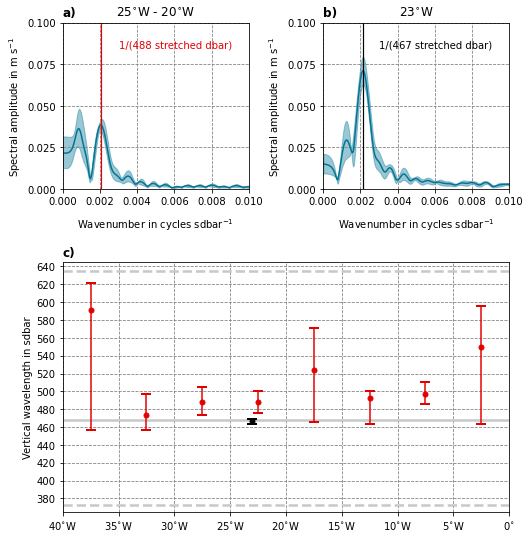

In [17]:
plt.figure(figsize=(8,9))

gr = gs.GridSpec(2, 2, hspace=0.35, wspace=0.4, height_ratios=[4,6])

ax1 = plt.subplot(gr[1, :])
#Youngs&Johnson data
plt.plot([-40,0], [373, 373], color="xkcd:silver", linestyle="dashed", linewidth=2.5)
plt.plot([-40,0], [467.5, 467.5], color="xkcd:silver", linestyle="solid", linewidth=2.5)
plt.plot([-40,0], [635, 635], color="xkcd:silver", linestyle="dashed", linewidth=2.5)
#our data
for i in range(2,10):
    plt.errorbar(density_dy2_filtered.lon[i], 1/freq_vel[maxind_all_vel[i]], 
             xerr=None, 
             yerr=np.asarray([(1/freq_vel[maxind_all_vel[i]] - 1/np.percentile(bootstrap_velocity[f"{i}"], 2.5)), 
                   (1/np.percentile(bootstrap_velocity[f"{i}"], 97.5) - 1/freq_vel[maxind_all_vel[i]])])[:,None], 
             fmt="none", ecolor="xkcd:red", capsize=5, capthick=2, zorder=46)
    plt.plot(density_dy2_filtered.lon[i], 1/freq_vel[maxind_all_vel[i]], marker=".", markersize=10, linestyle="None", color="xkcd:red")
plt.errorbar(-23, 1/freq_moor[maxind_moor], 
             xerr=None, 
             yerr=np.asarray([(1/freq_moor[maxind_moor] - 1/np.percentile(bootstrap_mooring["23"], 2.5)), 
                   (1/np.percentile(bootstrap_mooring["23"], 97.5) - 1/freq_moor[maxind_moor])])[:,None], 
             fmt="none", ecolor="black", capsize=5, capthick=2)
plt.plot(-23, 1/freq_moor[maxind_moor], marker=".", markersize=10, linestyle="None", color="black")
ax1.set_xlim([-40, 0])
ax1.set_xticks(np.arange(-40,5,5))
ax1.set_xticklabels([r"40$^{\circ}$W", r"35$^{\circ}$W", r"30$^{\circ}$W", r"25$^{\circ}$W", r"20$^{\circ}$W", r"15$^{\circ}$W", 
                     r"10$^{\circ}$W", r"5$^{\circ}$W", r"0$^{\circ}$"])
ax1.set_yticks(np.arange(380, 650, 20))
ax1.set_ylim([365, 645])
plt.title("c)", loc="left", fontweight="bold")
plt.ylabel("Vertical wavelength in sdbar")
plt.grid(color="grey", linestyle="dashed")
    
    
ax2 = plt.subplot(gr[0,0])
plt.fill_between(freq_vel, perc_25_vel, perc_75_vel, color="xkcd:sea blue", alpha=0.4)
plt.plot(freq_vel, mean_vel, color="xkcd:sea blue")
plt.plot([freq_vel[maxind_vel], freq_vel[maxind_vel]], [0, 1], color="xkcd:red", linestyle="solid", linewidth=1.2)
plt.text(0.003, 0.085, f"1/({round(1/freq_vel[maxind_vel]):.0f} stretched dbar)", color="xkcd:red")
ax2.set_ylim([0, 0.1])
ax2.set_xlim([0, 0.01])
plt.grid(linestyle="dashed", color="grey")
ax2.set_xticks(np.arange(0,0.012,0.002))
ax2.set_yticks(np.arange(0, 0.12, 0.025))
plt.xlabel(r"Wavenumber in cycles sdbar$^{-1}$", labelpad=10)
plt.ylabel(r"Spectral amplitude in m s$^{-1}$")
plt.title(r"25$^{\circ}$W - 20$^{\circ}$W")
plt.title("a)", loc="left", fontweight="bold")

ax3 = plt.subplot(gr[0,1])
plt.fill_between(freq_moor, perc_25_moor, perc_75_moor, color="xkcd:sea blue", alpha=0.4)
plt.plot(freq_moor, mean_moor, color="xkcd:sea blue")
plt.plot([freq_moor[maxind_moor], freq_moor[maxind_moor]], [0, 1], color="black", linewidth=1.2, linestyle="solid")
plt.text(0.003, 0.085, f"1/({round(1/freq_moor[maxind_moor]):.0f} stretched dbar)", color="black")
ax3.set_ylim([0, 0.1])
ax3.set_xlim([0, 0.01])
plt.grid(linestyle="dashed", color="grey")
ax3.set_xticks(np.arange(0,0.012,0.002))
ax3.set_yticks(np.arange(0, 0.12, 0.025))
plt.xlabel(r"Wavenumber in cycles sdbar$^{-1}$", labelpad=10)
plt.ylabel(r"Spectral amplitude in m s$^{-1}$");
plt.title(r"23$^{\circ}$W")
plt.title("b)", loc="left", fontweight="bold");

plt.savefig("Figures/Figure11_vertical_wavelength_velocity_harmonic_filter.pdf", bbox_inches="tight")

-----------------------
------------------
# Bootstrapping (for Figure 11c)

### 1 Define functions   
(lombscargle has to be defined here because dask workers cannot find module although it has been imported...)

In [ ]:
def lomb_scargle_profiles(dataset, freq = np.arange(0, 0.01, 0.00005), min_values=50):
    """Calculate Lomb-Scargle periodograms of all profiles containing data from either
    density gradient or geostrophic velocity dataset
    
    Input:
    dataarray (xarray dataarray): either density gradient profiles or geostrophic zonal velocity,
        on dimensions time and pressure
    
    Returns:
    freq, periodograms (numpy arrays): frequency axis and periodograms of all profiles containing data
    """
    
    amplitude = np.zeros(len(freq))[:, np.newaxis]
    
    for date in dataset.time.values:
        profile = dataset.sel(time=date)
        
        if np.sum(np.isfinite(profile.values)) > min_values: 
            data_temp = np.squeeze(profile.values[np.isfinite(profile.values)])
            pressure_temp = profile.pressure.values[np.squeeze(np.isfinite(profile.values))]
            
            power_temp = timeseries.LombScargle(pressure_temp, data_temp, normalization="psd").power(freq)
            # make normalization right
            amplitude_temp = np.sqrt(power_temp / len(pressure_temp)) * 2
            amplitude = np.append(amplitude, amplitude_temp[:, np.newaxis], axis=1)
            
    return freq, amplitude[:,1:]

In [ ]:
def resample_profile(data, pressure):   
    # draw sample from original data (with replacement and same length)
    inds = np.random.choice(np.arange(0, len(data)), size=len(data), replace=True)  # indices necessary for keeping integrity of data/pressure pairs
    sample_data = data[inds]
    sample_pressure = pressure[inds]
    return sample_data, sample_pressure

### 2 Mooring data

In [ ]:
# coarsening of mooring data (with 10dbar resolution, neighboring points are not independent and there 
# is too much duplicate information for the bootstrapping to work)
mooring_binned = mooring_stretched.coarsen(pressure=5, boundary="trim").mean()

In [ ]:
def resample_dataset(dataset):
    new_dataarray_values = np.zeros((len(dataset.pressure), len(dataset.time))) + np.nan
    for i in range(0, len(dataset.time)):
        sample_data, sample_pressure = resample_profile(dataset.u.isel(time=i).values[np.isfinite(dataset.u.isel(time=i).values)],
                                                        dataset.pressure.values[np.isfinite(dataset.u.isel(time=i).values)])
        for j in range(0, len(sample_pressure)):
            new_dataarray_values[(sample_pressure[j] == dataset.pressure), i] = sample_data[j]
    new_dataarray = xr.DataArray(new_dataarray_values, coords={"pressure": dataset.pressure,
                                                               "time": dataset.time,
                                                               "tdays": dataset.tdays}, dims=["pressure", "time"])
    return new_dataarray

# define function that does resampling of data, harmonic fitting at EDJ freq, and calculation of vertical wavenumbers
def frequency_estimation(N):   # N is dummy argument used for mapping N times to dask workers
    
    resampled_data = resample_dataset(mooring_binned)
    harmonic_data = fit_edj_harmonic(resampled_data)
    frequency, amplitude = lomb_scargle_profiles(harmonic_data, 
                                                             freq=np.arange(0, 0.01, 0.00001), min_values=10)
        
    dom_freq = frequency[np.nanargmax(np.mean(amplitude[150:250,:], axis=1)) + 150] 
    
    return dom_freq

In [ ]:
freqfutures_mooring = client.map(frequency_estimation, np.arange(0, 10000))    # calculate peak wavenumber 10,000 times

In [ ]:
%%time
frequencies_mooring = client.gather(freqfutures_mooring)

In [ ]:
freqs = np.asarray(frequencies_mooring)
# select only data between 0.0015 and 0.0025, to exclude profiles where the EDJ could not be detected
frequencies_edjs = dict()
for i in [23]:
    frequencies_edjs[f"{i}"] = freqs[(freqs > 0.0015) & (freqs < 0.0025)]
    
savemat("derived_data/vertical_wavenumbers_bootstrapping_temporal_harmonic_mooring.mat", frequencies_edjs)

### 3 Reconstructed velocity data
(Bootstrapping: first resampling (of unstretched d2rho/dy2), then temporal harmonic filter, then velocity reconstruction, then stretching and scaling, then spectra and peak wavelength)

In [ ]:
# define stretched vertical coordinate 
dz_o = velocity_temporalharmonic_detrended_scaled.sel(pressure=slice(410,2000)).pressure.diff(dim="pressure")
dz_s = dz_o * N_m.N_m / N_zero
stretched_pressure = np.cumsum(dz_s) + 410

In [ ]:
def resample_dataset(dataset):
    new_dataarray_values = np.zeros((len(dataset.time), len(dataset.pressure), len(dataset.lon))) + np.nan
    for i in range(0, len(dataset.time)):
        for k in range(0, len(dataset.lon)):
            sample_data, sample_pressure = resample_profile(dataset.density_dy2.isel(time=i, lon=k).values[np.isfinite(dataset.density_dy2.isel(time=i, lon=k).values)],
                                                        dataset.pressure.values[np.isfinite(dataset.density_dy2.isel(time=i, lon=k).values)])
            for j in range(0, len(sample_pressure)):
                new_dataarray_values[i, (sample_pressure[j] == dataset.pressure), k] = sample_data[j]
    new_dataarray = xr.DataArray(new_dataarray_values, coords={"pressure": dataset.pressure,
                                                               "time": dataset.time,
                                                               "lon": dataset.lon,
                                                               "tdays": dataset.tdays}, dims=["time", "pressure", "lon"])
    return new_dataarray

# define function that does resampling of data, harmonic fitting at EDJ freq, velocity reconstruction, and calculation of vertical wavenumbers
def frequency_estimation(N):   # N is dummy argument used for mapping N times to dask workers
    
    dom_freq = np.zeros(12) + np.nan
 
    # resampling
    resampled_data = resample_dataset(density_dy2.sel(pressure=slice(410,2000)).squeeze())

    # temporal harmonic filter
    density_dy2_filtered = fit_edj_harmonic(resampled_data, tdays=density_dy2.tdays)

    # velocity reconstruction
    _, velocity_data_detrended = zonal_velocity_reconstruction(
        density_dy2_filtered.transpose("time", "pressure", "lon"), 
        rho_profile.sel(pressure=slice(410,2000)), ref_u_filtered, 1e5, p_ref_u=1000)
    
    
    # scale and stretch
    velocity_detrended_scaled = velocity_data_detrended / (N_m.N_m.sel(pressure=slice(410,2000)) / N_zero)**0.5
   
    # new_dataset
    vel_detr_scaled_stretched = xr.Dataset({"u": (["time", "pressure", "lon"], 
                                                       velocity_detrended_scaled.detrended_u.transpose("time", "pressure", "lon").values[:,:-1,:])},
                              coords={"pressure": (["pressure"], stretched_pressure.values),
                                      "unstretched_pressure": (["pressure"], velocity_detrended_scaled.sel(pressure=slice(410,1990)).pressure),
                                      "time": (["time"], velocity_detrended_scaled.time),
                                      "lon": (["lon"], velocity_detrended_scaled.lon)})
    
    for i in range(0, 12):
        frequency, amplitude = lomb_scargle_profiles(vel_detr_scaled_stretched.u.isel(lon=i), 
                                                             freq=np.arange(0, 0.01, 0.00001), min_values=50)
        
        if amplitude.shape[1] > 3:
            dom_freq[i] = frequency[np.nanargmax(np.mean(amplitude[150:250,:], axis=1)) + 150]
    
    return dom_freq

In [ ]:
freqfutures = client.map(frequency_estimation, np.arange(0, 5000))

In [ ]:
%%time
frequencies = client.gather(freqfutures)

In [ ]:
freqs = np.asarray(frequencies)
# select only data between 0.0015 and 0.0025
frequencies_edjs = dict()
for i in range(0,12):
    frequencies_edjs[f"{i}"] = freqs[:,i][(freqs[:,i] > 0.0015) & (freqs[:,i] < 0.0025)]
    
savemat("derived_data/vertical_wavenumbers_bootstrapping_velocity.mat", frequencies_edjs)